In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))
    return acc

torch.manual_seed(42)

def eval_model(model: torch.nn.Module, loader, loss_fn, accuracy_fn, device):
    """returns a dic containing results of model on loader"""
    loss = 0
    acc = 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(loader):
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y).item()
            acc += accuracy_fn(y, y_pred.argmax(dim = 1))
    loss /= len(loader)
    acc /= len(loader)
    return {
        "model_name": model.__class__.__name__,
        "loss": loss,
        "accuracy": acc
    }

### 1. Prepare Data

#### 1.1 Define Dataset and Loaders

In [ ]:
train_data = datasets.FashionMNIST(root = 'data', train = True, download = True,
                                   transform = ToTensor(), # how to transform data
                                   target_transform = None) # how to transform labels

test_data = datasets.FashionMNIST(root = 'data', train = False, download = True,
                                  transform = ToTensor(),
                                  target_transform = None)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 222kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.45MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(train_data, BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle = False)
# test order doesn't matter
len(train_loader), len(test_loader)

(1875, 313)

#### 1.2 Explore Data Formats

In [ ]:
print('records in train and test data:', len(train_data), len(test_data))

image, label = train_data[0] # a tuple of (1*28*28 tensor, a number label)
print(image.shape, label)

records in train and test data: 60000 10000
torch.Size([1, 28, 28]) 9


In [ ]:
class_names = train_data.classes # class_names[targetidx] -> output stuff
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
train_data.targets # get labels

tensor([9, 0, 0,  ..., 3, 0, 5])

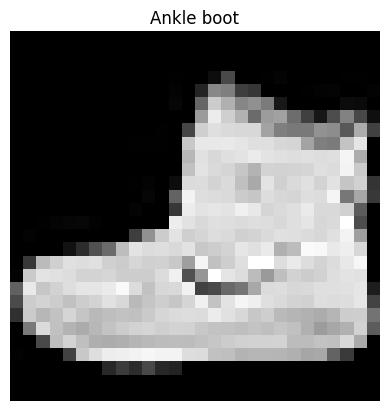

In [ ]:
plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(class_names[label])
plt.axis(False)
plt.show()

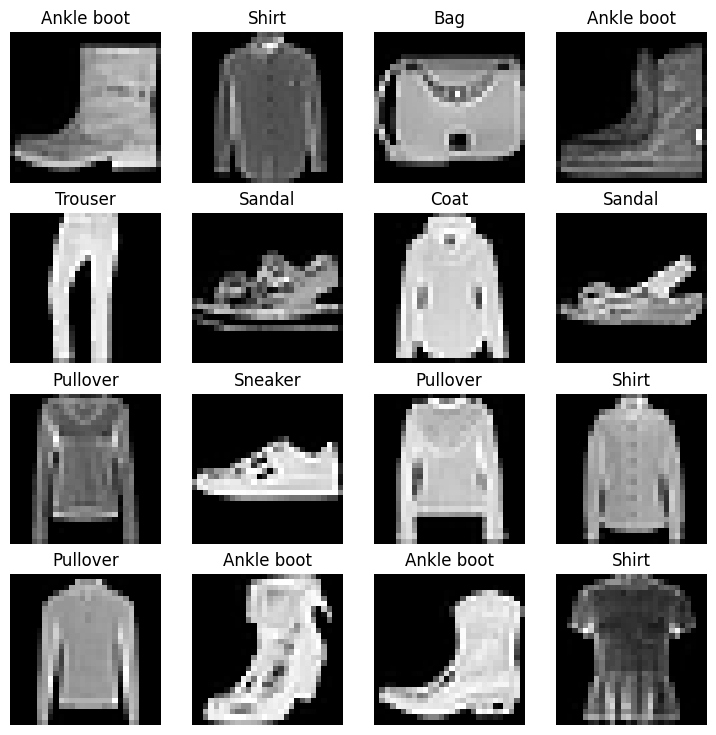

In [ ]:
torch.manual_seed(42)
plt.figure(figsize = (9, 9))

rows, cols = 4, 4
for i in range(rows * cols):
    random_idx = torch.randint(0, len(train_data), (1, 1)).item()
    image, label = train_data[random_idx]
    plt.subplot(4, 4, i + 1)
    plt.imshow(image.squeeze(), cmap = 'gray')
    plt.title(class_names[label])
    plt.axis(False)

In [ ]:
train_data_batch, train_label_batch = next(iter(train_loader))
train_data_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

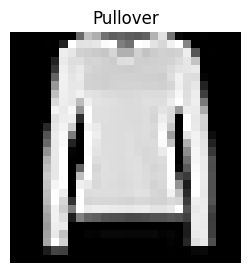

In [ ]:
random_idx = torch.randint(0, len(train_data_batch), size = (1, 1)).item()
plt.figure(figsize = (3, 3))
plt.imshow(train_data_batch[random_idx].squeeze(), cmap = 'gray')
plt.title(class_names[train_label_batch[random_idx]])
plt.axis(False)
plt.show()

### 2 - Model; MLP with no spatial

#### 2.1 - define

In [ ]:
# MLP model for baseline

class Model0(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(in_features = input_shape,
                                out_features = 64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(in_features = 64,
                                out_features = output_shape)

    def forward(self, x):
        res = self.flatten(x)
        res = self.layer1(res)
        res = self.relu(res)
        res = self.layer2(res)
        return res

In [ ]:
model0 = Model0(input_shape = 784, output_shape = 10)

model0(torch.rand((1, 1, 28, 28)))

tensor([[-0.2851, -0.0375, -0.0882, -0.0155, -0.1381,  0.1222,  0.2051, -0.0090,
         -0.1525,  0.1585]], grad_fn=<AddmmBackward0>)

#### 2.2 - train

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model0.parameters(),
                             lr = 0.1)

In [ ]:
torch.manual_seed(42)

In [ ]:
EPOCHS = 3

for epoch in range(EPOCHS):
    print(f'---EPOCH {epoch + 1}---')
    train_loss = 0
    model0.train()
    for X_train, y_train in tqdm(train_loader):
        y_train_pred = model0(X_train)
        loss = loss_fn(y_train_pred, y_train)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    test_loss, test_acc = 0, 0
    model0.eval()
    with torch.inference_mode():
        for X_test, y_test in tqdm(test_loader):
            y_test_pred = model0(X_test)
            loss = loss_fn(y_test_pred, y_test)
            test_loss += loss.item()
            test_acc += accuracy_fn(y_test, y_test_pred.argmax(dim = 1))
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    print(f'train_loss: {train_loss:.4f}')
    print(f'test_loss: {test_loss:.4f}')
    print(f'test_accuracy: {test_acc:.4f}')


---EPOCH 1---


100%|██████████| 313/313 [00:01<00:00, 207.00it/s]


train_loss: 1.7764
test_loss: 1.8953
test_accuracy: 0.3262
---EPOCH 2---


100%|██████████| 313/313 [00:01<00:00, 219.02it/s]


train_loss: 1.9680
test_loss: 1.7765
test_accuracy: 0.2845
---EPOCH 3---


100%|██████████| 313/313 [00:01<00:00, 223.68it/s]

train_loss: 1.8218
test_loss: 1.7562
test_accuracy: 0.3217


#### 2.3 - eval

In [ ]:
model0_results = eval_model(model0, test_loader, nn.CrossEntropyLoss(),
                             accuracy_fn, device = 'cpu')
model0_results

100%|██████████| 313/313 [00:01<00:00, 204.92it/s]


{'model_name': 'Model0',
 'loss': 1.6677975883118261,
 'accuracy': 0.30581070287539935}

### 3 - Model: CNN

#### 3.1 - define

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self, input_channels, output_dimensions):
        super().__init__()
        self.conv_layer1 = nn.Conv2d(in_channels = input_channels,
                                     out_channels = 8, kernel_size = (3, 3),
                                     stride = 1, padding = 1)
        self.relu = nn.ReLU()
        self.conv_layer2 = nn.Conv2d(in_channels = 8,
                                     out_channels = 8, kernel_size = (4, 4),
                                     stride = 1, padding = 1)
        self.maxpool1 = nn.MaxPool2d(kernel_size = (2, 2))

        self.conv_layer3 = nn.Conv2d(in_channels = 8,
                                     out_channels = 8, kernel_size = (3, 3),
                                     stride = 1, padding = 1)

        self.conv_layer4 = nn.Conv2d(in_channels = 8,
                                     out_channels = 8, kernel_size = (4, 4),
                                     stride = 1, padding = 1)

        self.maxpool2 = nn.MaxPool2d(kernel_size = (2, 2))
        self.flatten = nn.Flatten()

        # need to hand calculate, or pass the previous layers
        # in the forward and inspect output shape
        calculated_features = 288
        self.linear1 = nn.Linear(in_features = calculated_features,
                                 out_features = 32)
        self.linear2 = nn.Linear(in_features = 32,
                                 out_features = output_dimensions)

    def forward(self, x):
        res = self.conv_layer1(x)
        res = self.relu(res)
        res = self.conv_layer2(res)
        res = self.relu(res)
        res = self.maxpool1(res)

        res = self.conv_layer3(res)
        res = self.relu(res)
        res = self.conv_layer4(res)
        res = self.relu(res)
        res = self.maxpool2(res)
        res = self.flatten(res)
        res = self.linear1(res)
        res = self.relu(res)
        res = self.linear2(res)
        return res

    # def forward(self, x):
    #     res = self.conv_layer1(x)
    #     res = self.relu(res)
    #     res = self.conv_layer2(res)
    #     res = self.relu(res)
    #     res = self.maxpool(res)

    #     res = self.conv_layer3(res)
    #     res = self.relu(res)
    #     res = self.conv_layer4(res)
    #     res = self.relu(res)
    #     res = self.maxpool(res)
    #     res = self.flatten(res)
    #     return res

    # then run:
    # train_data_batch, train_label_batch = next(iter(train_loader))
    # model1 = CNN_Model(1, 10)
    # model1(train_data_batch).shape
    # to get 392

In [ ]:
train_data_batch, train_label_batch = next(iter(train_loader))
model1 = CNN_Model(1, 10).to(device)
model1(train_data_batch.to(device)).argmax(dim = 1)

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')

#### 3.2 - train

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model1.parameters(),
                             lr = 0.01)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f'---epoch {epoch + 1}---')
    train_loss = 0
    model1.train()
    for X_train, y_train in tqdm(train_loader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        y_train_pred = model1(X_train)
        loss = loss_fn(y_train_pred, y_train)

        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    test_loss, test_acc = 0, 0
    model1.eval()
    with torch.inference_mode():
        for X_test, y_test in tqdm(test_loader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_test_pred = model1(X_test)
            loss = loss_fn(y_test_pred, y_test)
            test_loss += loss.item()
            test_acc += accuracy_fn(y_test, y_test_pred.argmax(dim = 1))
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print(f'train_loss: {train_loss:.4f}')
    print(f'test_loss: {test_loss:.4f}')
    print(f'test_accuracy: {test_acc:.4f}')

---epoch 1---


100%|██████████| 313/313 [00:01<00:00, 243.47it/s]


train_loss: 0.5178
test_loss: 0.4252
test_accuracy: 0.8408
---epoch 2---


100%|██████████| 313/313 [00:01<00:00, 246.77it/s]


train_loss: 0.4055
test_loss: 0.4050
test_accuracy: 0.8495
---epoch 3---


100%|██████████| 313/313 [00:01<00:00, 237.24it/s]


train_loss: 0.3852
test_loss: 0.3835
test_accuracy: 0.8596
---epoch 4---


100%|██████████| 313/313 [00:01<00:00, 246.89it/s]


train_loss: 0.3775
test_loss: 0.3994
test_accuracy: 0.8530
---epoch 5---


100%|██████████| 313/313 [00:01<00:00, 243.63it/s]


train_loss: 0.3701
test_loss: 0.4103
test_accuracy: 0.8485
---epoch 6---


100%|██████████| 313/313 [00:01<00:00, 203.98it/s]


train_loss: 0.3681
test_loss: 0.3960
test_accuracy: 0.8520
---epoch 7---


100%|██████████| 313/313 [00:01<00:00, 185.14it/s]


train_loss: 0.3679
test_loss: 0.4088
test_accuracy: 0.8526
---epoch 8---


100%|██████████| 313/313 [00:01<00:00, 247.25it/s]


train_loss: 0.3635
test_loss: 0.3703
test_accuracy: 0.8656
---epoch 9---


100%|██████████| 313/313 [00:01<00:00, 192.85it/s]


train_loss: 0.3580
test_loss: 0.3872
test_accuracy: 0.8577
---epoch 10---


100%|██████████| 313/313 [00:01<00:00, 249.28it/s]

train_loss: 0.3597
test_loss: 0.3859
test_accuracy: 0.8628


#### 3.3 - eval

In [ ]:
model1_results = eval_model(model1, test_loader, loss_fn,
                            accuracy_fn = accuracy_fn,
                            device = device)
model1_results

100%|██████████| 313/313 [00:01<00:00, 245.67it/s]


{'model_name': 'CNN_Model',
 'loss': 0.3858805971261792,
 'accuracy': 0.8628194888178914}

### 4 - compare results

In [ ]:
import pandas as pd

compare_results = pd.DataFrame([model0_results, model1_results])
compare_results

,model_name,loss,accuracy
0,Model0,1.667798,0.305811
1,CNN_Model,0.385881,0.862819


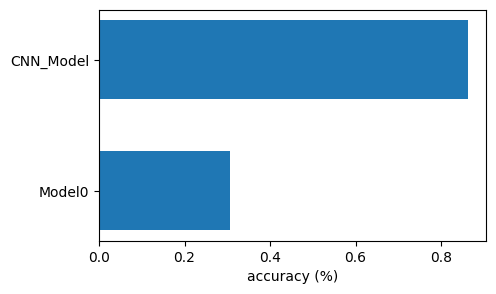

In [ ]:
plt.figure(figsize = (5, 3))
plt.barh(compare_results['model_name'], compare_results['accuracy'], height = 0.6)
plt.xlabel('accuracy (%)')
plt.show()

In [ ]:
def make_predictions(model, data, device):
    """
    take in list of tensors (each tensor = 1*28*28)
    return prediction in probability after softmax
    """
    pred_probs = None
    model.eval()
    with torch.inference_mode():
        sample = torch.stack(data).to(device)

        pred_logits = model(sample)
        pred_prob = torch.softmax(pred_logits.squeeze(), dim = 1).to('cpu')
    return pred_prob.numpy()

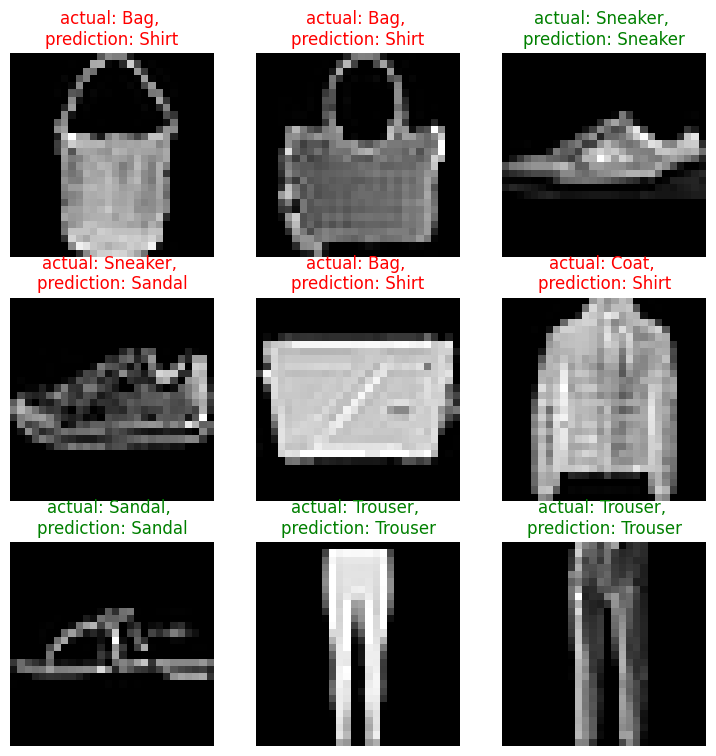

In [ ]:
# for MLP model
# extract 9 samples
test_samples = []
test_labels = []

for i in range(9):
    rd_idx = torch.randint(0, len(test_data), size=(1, 1)).item()
    data, label = test_data[rd_idx]
    test_samples.append(data)
    test_labels.append(label)

# then plot predictions
plt.figure(figsize = (9, 9))
predicted = make_predictions(model0, test_samples, 'cpu').argmax(axis = 1)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_samples[i].squeeze(), cmap = 'grey')
    plt.axis(False)
    truth = class_names[test_labels[i]]
    pred = class_names[predicted[i]]
    if pred == truth:
        plt.title(f'actual: {truth}, \nprediction: {pred}', c = 'g')
    else:
        plt.title(f'actual: {truth}, \nprediction: {pred}', c = 'r')

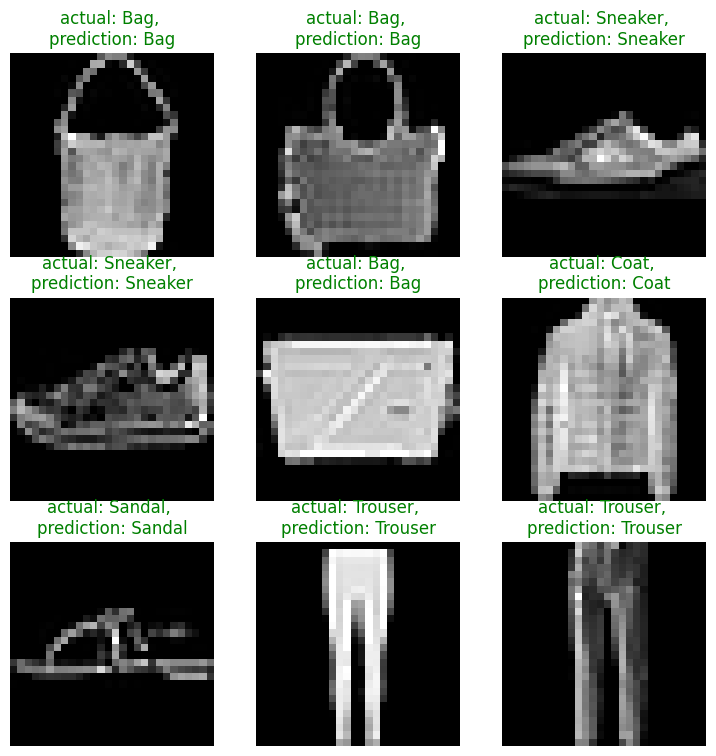

In [ ]:
# then plot predictions for CNN
plt.figure(figsize = (9, 9))
predicted = make_predictions(model1, test_samples, device).argmax(axis = 1)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_samples[i].squeeze(), cmap = 'grey')
    plt.axis(False)
    truth = class_names[test_labels[i]]
    pred = class_names[predicted[i]]
    if pred == truth:
        plt.title(f'actual: {truth}, \nprediction: {pred}', c = 'g')
    else:
        plt.title(f'actual: {truth}, \nprediction: {pred}', c = 'r')

In [ ]:
# plot confusion matrix for CNN
from sklearn import metrics

def confusion_matrix(model, loader, device):
    truth = []
    pred = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(loader):
            truth.extend(list(y.to('cpu').numpy()))
            X = X.to(device)
            y_pred = model(X).argmax(dim = 1).to('cpu').numpy()
            pred.extend(list(y_pred))

    cm = metrics.confusion_matrix(truth, pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                        display_labels = class_names)

    cm_display.plot()
    plt.xticks(rotation = 30)
    plt.show()

100%|██████████| 313/313 [00:01<00:00, 298.01it/s]


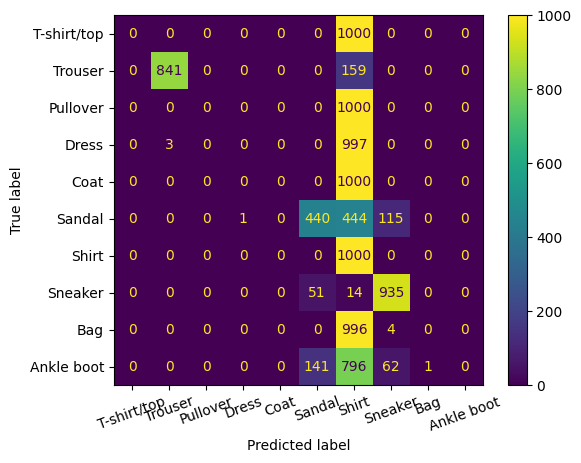

In [ ]:
# for mlp
confusion_matrix(model0, test_loader, 'cpu')

100%|██████████| 313/313 [00:01<00:00, 260.22it/s]


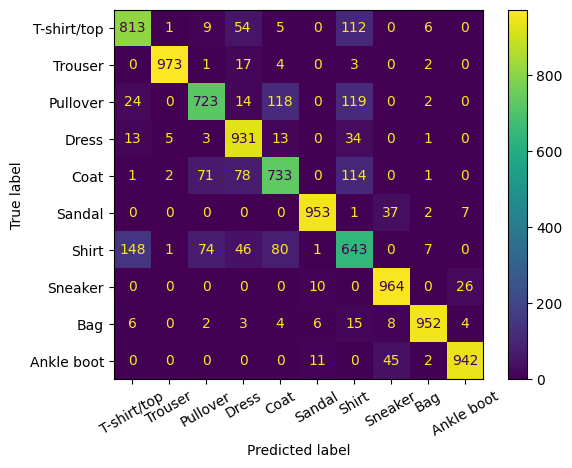

In [ ]:
# for cnn
confusion_matrix(model1, test_loader, device)

### 5 - save model

In [ ]:
PATH = 'Torch03_Computer_Vision_CNN.pth'
torch.save(model1.state_dict(), PATH)

In [ ]:
# load:
model1 = CNN_Model(1, 10).to(device)
model1.load_state_dict(torch.load(PATH))

<ipython-input-134-ca973f340d12>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load(PATH))


<All keys matched successfully>